<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

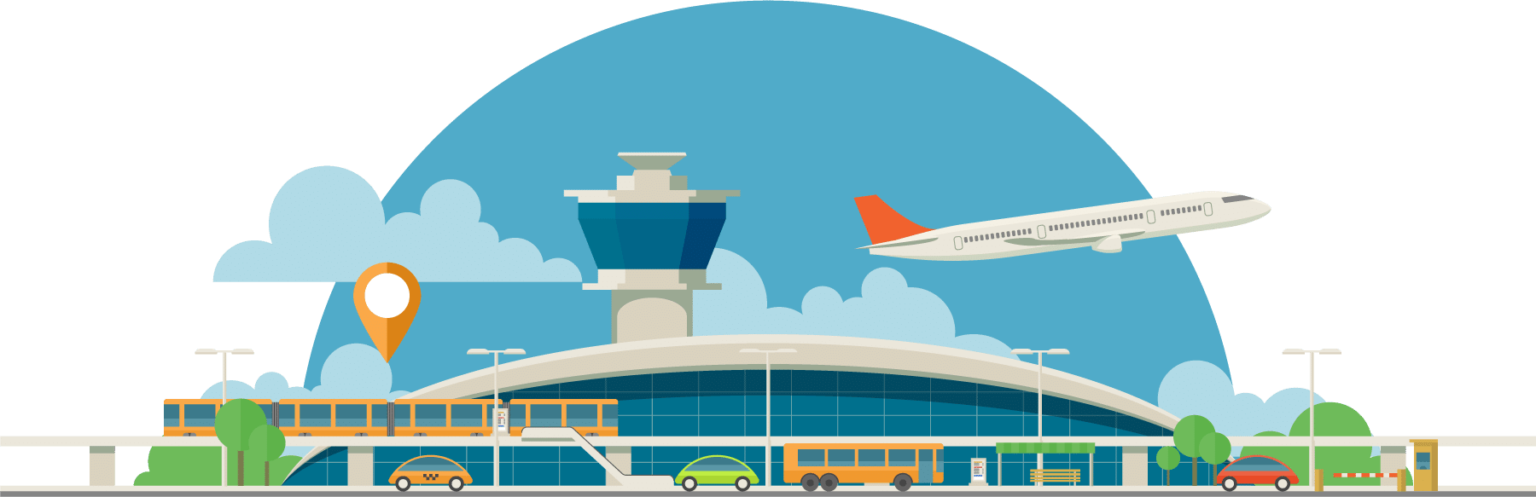

In [168]:
# установка всех библиотек, необходимых для выполнения ДЗ

#!pip install catboost
#!pip install mlxtend --upgrade
#!pip install optuna
#!pip install lime
#!pip install shap
#!pip install missingno
#!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [170]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

�訡�� � ᨭ⠪�� �������.


### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

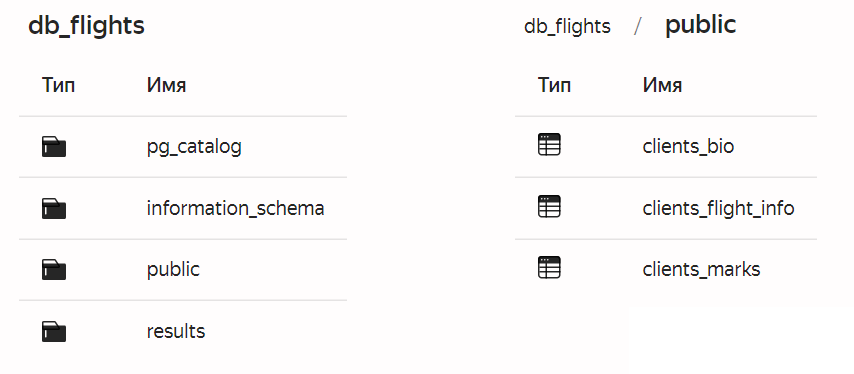



In [171]:
try:
    connection = psycopg2.connect(
        dbname="db_flights",
        user="mlhs_student",
        password="mlhs_student",
        host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
        port="6432",
        sslmode="verify-full",
        target_session_attrs="read-write"
    )
    print("Подключение к базе данных успешно установлено.")
except Exception as error:
    print("Ошибка при подключении к базе данных:", error)

query = """
   SELECT *
   FROM public.clients_bio t1
   JOIN public.clients_flight_info t2 ON t1.id = t2.id
   JOIN public.clients_marks t3 ON t1.id = t3.id
   """

Подключение к базе данных успешно установлено.


In [172]:
df = pd.read_sql_query(query, connection)

C:\Users\vdl\AppData\Local\Temp\ipykernel_16188\498374113.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [173]:
df = df.set_index(df.iloc[:, 0]).drop(columns='id')

In [174]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [175]:
df.dtypes

gender                               object
age                                  object
Customer Type                        object
Type of Travel                       object
class                                object
Flight Distance                      object
Departure Delay in Minutes           object
Arrival Delay in Minutes             object
Inflight wifi service                object
Departure/Arrival time convenient    object
Ease of Online booking               object
Gate location                        object
Food and drink                       object
Online boarding                      object
Seat comfort                         object
Inflight entertainment               object
On-board service                     object
Leg room service                     object
Baggage handling                     object
Checkin service                      object
Inflight service                     object
cleanliness                          object
satisfaction                    

In [176]:
for column in df.columns:
    try:
        df[column] = df[column].astype(float)
    except:
        print(f'Column "{column}" is not numeric')

Column "gender" is not numeric
Column "Customer Type" is not numeric
Column "Type of Travel" is not numeric
Column "class" is not numeric
Column "satisfaction" is not numeric


In [177]:
df.isna().sum().sum()

1664

In [178]:
df.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,129234.000000,129455.000000,129442.000000,129042.000000,129505.000000,129500.000000,129506.000000,129512.000000,129499.000000,129503.000000,129502.000000,129504.000000,129505.000000,129503.000000,129501.000000,129507.000000,129486.000000,129512.000000
mean,40.116951,1322.922158,15.809026,16.656499,2.732327,3.062131,2.760722,2.981708,3.208141,3.256782,3.445669,3.361232,3.387259,3.355976,3.635872,3.309976,3.646927,3.289780
std,20.376129,4517.816532,93.276882,109.285072,1.360033,1.559627,1.431048,1.312873,1.357546,1.381888,1.349713,1.366908,1.335697,1.361670,1.222039,1.298827,1.218748,1.347466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,846.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,621.000000,379620.000000,22227.000000,14006.000000,45.000000,45.000000,45.000000,36.000000,45.000000,40.000000,45.000000,45.000000,45.000000,40.000000,40.000000,45.000000,40.000000,45.000000


### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Figure size 1000x600 with 0 Axes>

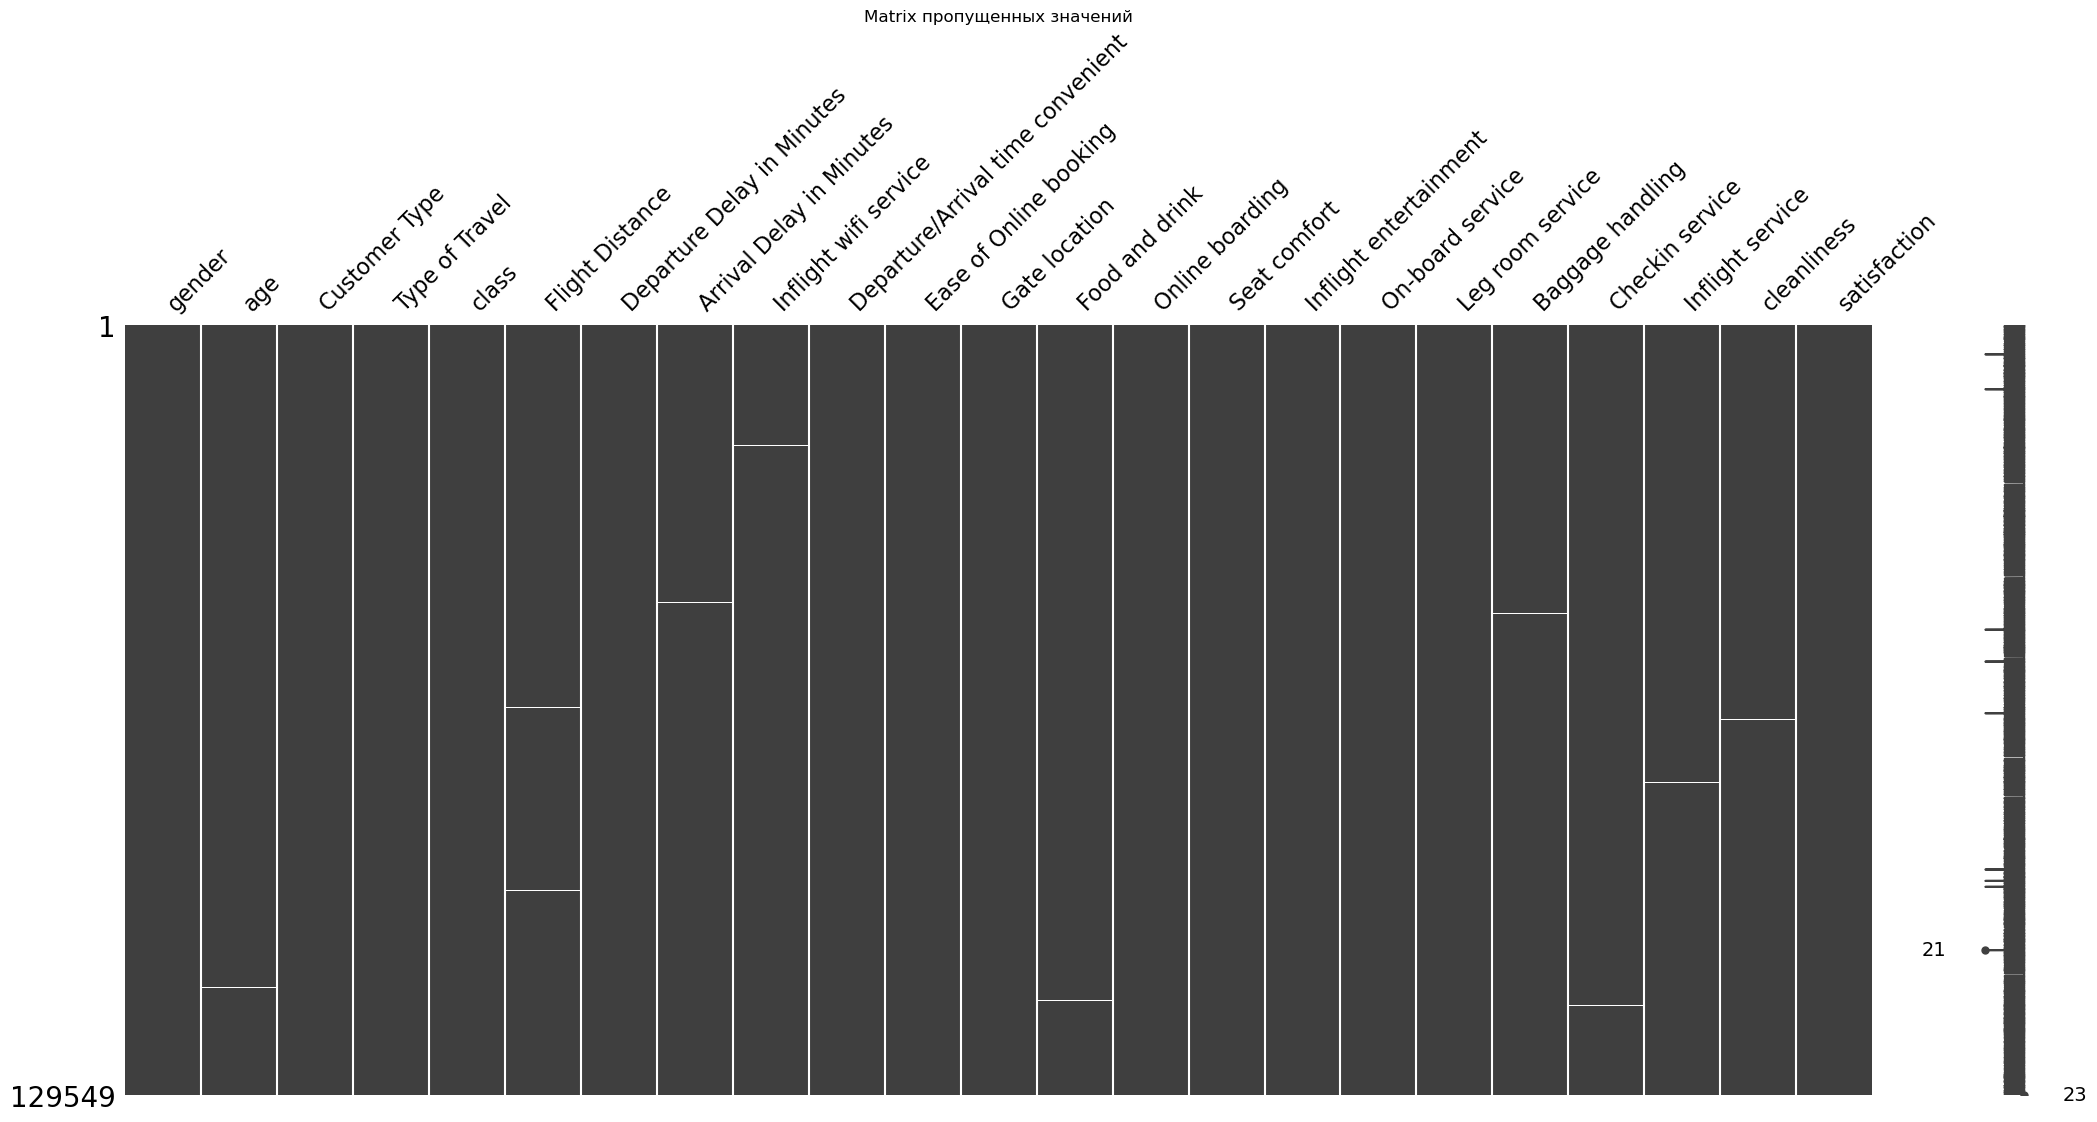

In [179]:
plt.figure(figsize=(10, 6))
missingno.matrix(df)
plt.title('Matrix пропущенных значений')
plt.show()

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\missingno\missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


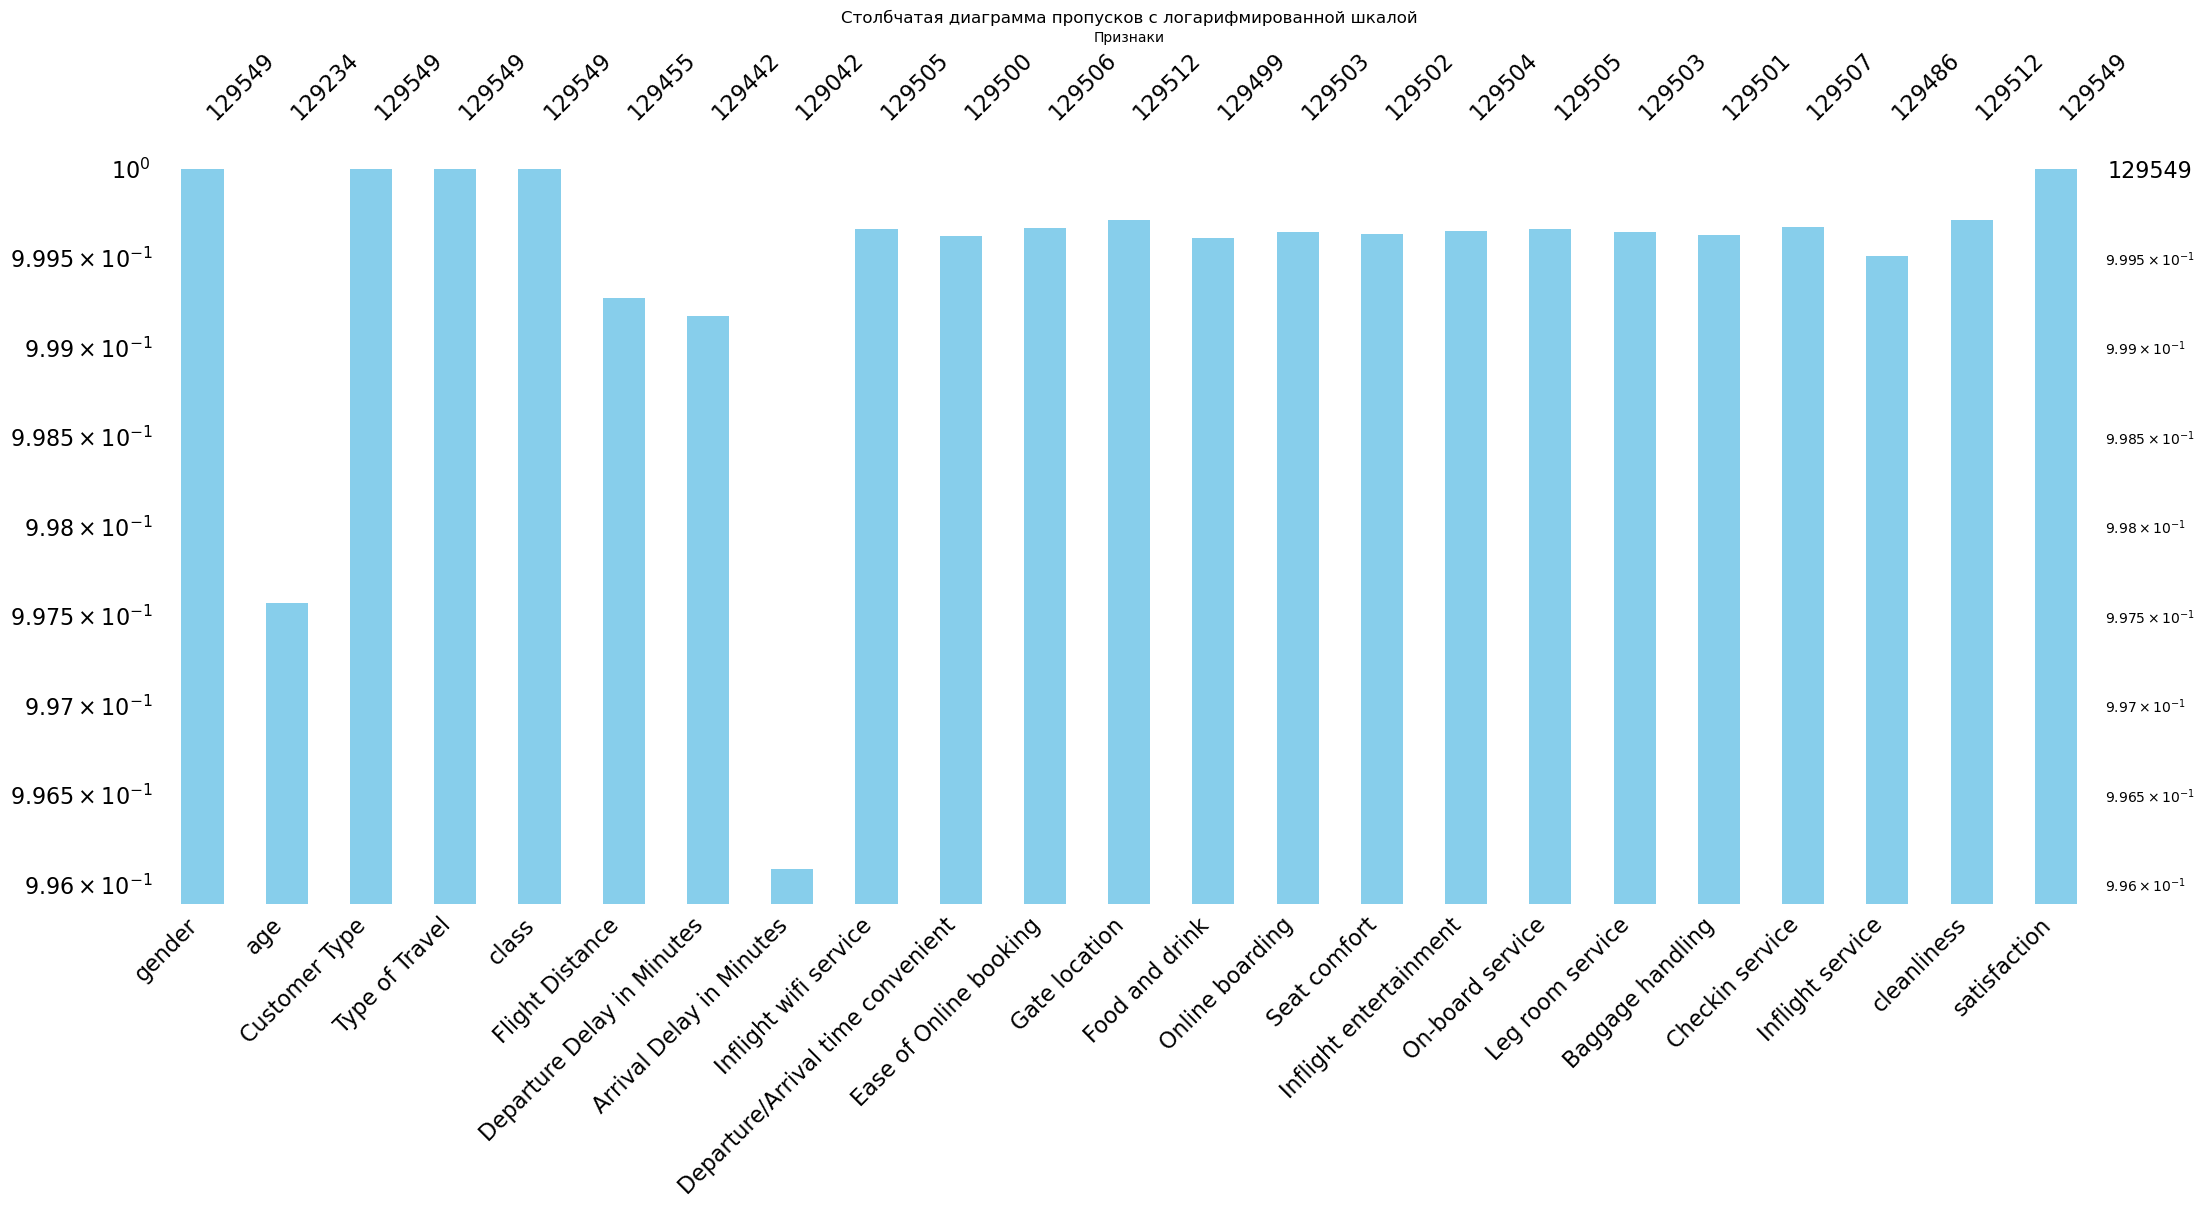

In [180]:
# 2. Столбчатая диаграмма пропусков с логарифмированной шкалой
plt.figure(figsize=(10, 6))
missingno.bar(df, color='skyblue', log=True)
plt.title('Столбчатая диаграмма пропусков с логарифмированной шкалой')
plt.xlabel('Признаки')
plt.ylabel('Кол-во пропущенных значений')
plt.show()

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [181]:
df_train = df[df.satisfaction != '-']
df_train

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129831,Female,28.0,Loyal Customer,Personal Travel,Eco,447.0,23.0,16.0,1.0,3.0,...,1.0,3.0,3.0,1.0,1.0,4.0,1.0,5.0,3.0,neutral or dissatisfied
129837,Male,66.0,Loyal Customer,Personal Travel,Eco,337.0,199.0,213.0,2.0,4.0,...,5.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,5.0,neutral or dissatisfied
129838,Female,59.0,Loyal Customer,Personal Travel,Eco,308.0,32.0,24.0,3.0,5.0,...,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,neutral or dissatisfied


In [182]:
assert df_train.shape == (103_644, 23)

In [183]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,
55,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,1.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
79,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,5.0,4.0,...,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
126,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,2.0,5.0,...,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
199,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,4.0,4.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
263,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,1.0,2.0,...,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129750,Male,38.0,Loyal Customer,Business travel,Eco,337.0,92.0,82.0,4.0,3.0,...,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,3.0,4.0
129771,Male,16.0,Loyal Customer,Personal Travel,Eco,308.0,2.0,0.0,3.0,4.0,...,1.0,3.0,5.0,1.0,4.0,2.0,5.0,5.0,4.0,1.0
129798,Female,43.0,Loyal Customer,Personal Travel,Eco,308.0,0.0,0.0,2.0,4.0,...,3.0,5.0,5.0,4.0,4.0,2.0,4.0,4.0,4.0,5.0


In [184]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [185]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [186]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [187]:
for col in X_train.columns:
    X_train[col] = X_train[col].apply(lambda x: X_train[col].mode()[0] if str(x) == 'nan' else x)
    X_val[col] = X_val[col].apply(lambda x: X_train[col].mode()[0] if str(x) == 'nan' else x)

In [188]:
def checking_nan_in_df(df):
    for col in df.columns:
        if 'nan' in df[col].to_list():
            print(f'nan есть в столбце {col}')
        
checking_nan_in_df(X_train)
checking_nan_in_df(X_val)

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [189]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(numerics).describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,129234.000000,129455.000000,129442.000000,129042.000000,129505.000000,129500.000000,129506.000000,129512.000000,129499.000000,129503.000000,129502.000000,129504.000000,129505.000000,129503.000000,129501.000000,129507.000000,129486.000000,129512.000000
mean,40.116951,1322.922158,15.809026,16.656499,2.732327,3.062131,2.760722,2.981708,3.208141,3.256782,3.445669,3.361232,3.387259,3.355976,3.635872,3.309976,3.646927,3.289780
std,20.376129,4517.816532,93.276882,109.285072,1.360033,1.559627,1.431048,1.312873,1.357546,1.381888,1.349713,1.366908,1.335697,1.361670,1.222039,1.298827,1.218748,1.347466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,846.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,621.000000,379620.000000,22227.000000,14006.000000,45.000000,45.000000,45.000000,36.000000,45.000000,40.000000,45.000000,45.000000,45.000000,40.000000,40.000000,45.000000,40.000000,45.000000


In [190]:
df.select_dtypes(object).describe()

,gender,Customer Type,Type of Travel,class,satisfaction
count,129549,129549,129549,129549,129549
unique,2,3,3,4,3
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,65726,105763,89405,61939,58732


Числовые признаки:

В датасете есть объекты с нулевым признаком Flight Distance, с неадекватно большими значениями age, delays и всех признаков с оценками аспектов полета, ибо судя по средним значениям Flight Distance исчисляется в километрах, age в годах, а оценки должны быть в 5-ти или 10-тибальной шкале

Категориальные признаки:

Данные неравномерные. На самые частоповторяющиеся значения приходится от 50 до 80 % выборки

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [191]:
for col in X_train.select_dtypes(numerics).columns:
    y_train = y_train[X_train[col] <= X_train[col].quantile(0.996)]
    X_train = X_train[X_train[col] <= X_train[col].quantile(0.996)]
    y_val = y_val[X_val[col] <= X_val[col].quantile(0.996)]
    X_val = X_val[X_val[col] <= X_val[col].quantile(0.996)]

In [192]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [193]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [194]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [195]:
"""Draws countplots for all columns in 'cols' with informative title"""
def plot_ordinal(cols, df, y):
    for col in cols:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=col, hue=y, palette='tab10')
        plt.title(f'Распределение признака {col} по целевой переменной')
        plt.xlabel('Признак')
        plt.ylabel('Количество')
        plt.legend(title='Целевая переменная', loc='best')
        plt.show()


In [196]:
"""Draws kdeplots and boxplots in one row
for all columns in 'cols' with informative title
"""
def plot_continuous(cols, df, y):
    for col in cols:
        plt.figure(figsize=(18, 3))
        plt.suptitle(f'Признак {col}')

        plt.subplot(1, 2, 1)
        data = pd.merge(df[col], y, left_index=True, right_index=True)
        for y_value in y.unique():
            sns.kdeplot(data=data[data['satisfaction'] == y_value], 
                        x=col, 
                        fill=True, 
                        common_norm=False, 
                        label=f'Целевая переменная:\n{y_value}')
        plt.title(f'Плотность распределения значений признака\nпо целевой переменной')
        plt.xlabel('Признак')
        plt.ylabel('Плотность распределения')
        plt.legend(title='Целевая переменная', prop={'size': 8}, loc='best')

        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x=col, orient='v', flierprops={'marker':'x', 'markersize':3})
        plt.title('Ящик с усами')
        plt.xlabel(f'Значения признака {col}')

        plt.show()

In [197]:
"""Draws countplots for all columns in 'cols' with informative title"""
def plot_categorical(cols, df, y):
    for col in cols:
        plt.figure(figsize=(12, 5))
        sns.countplot(data=df, x=col, hue=y, palette='tab10')
        plt.xlabel('Признак')
        plt.ylabel('Количество')
        plt.legend(title='Целевая переменная', loc='best')
        plt.show()

Отрисовка.

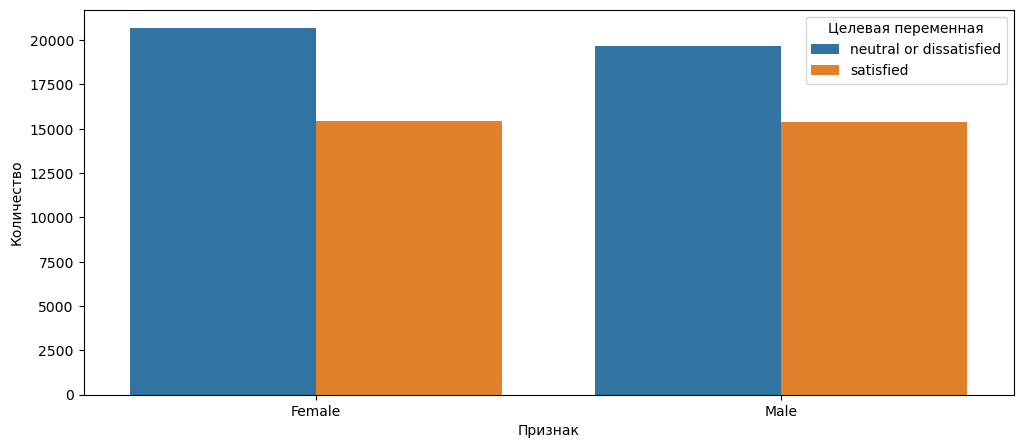

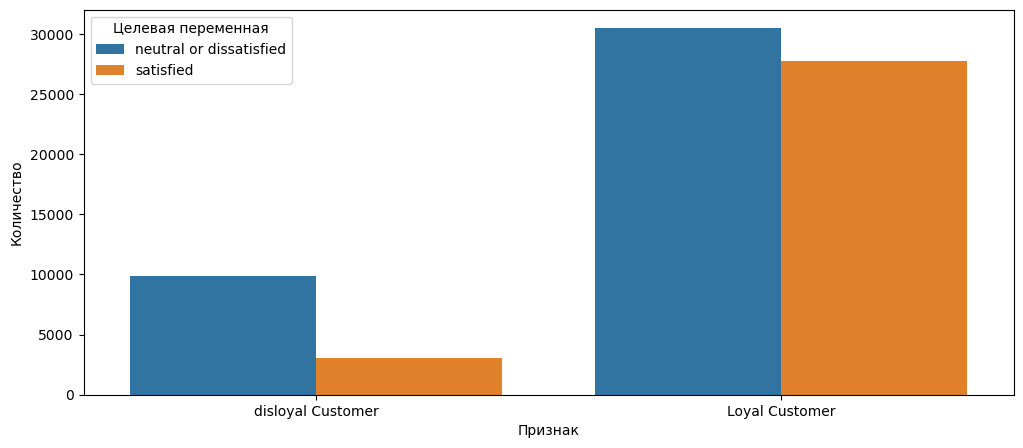

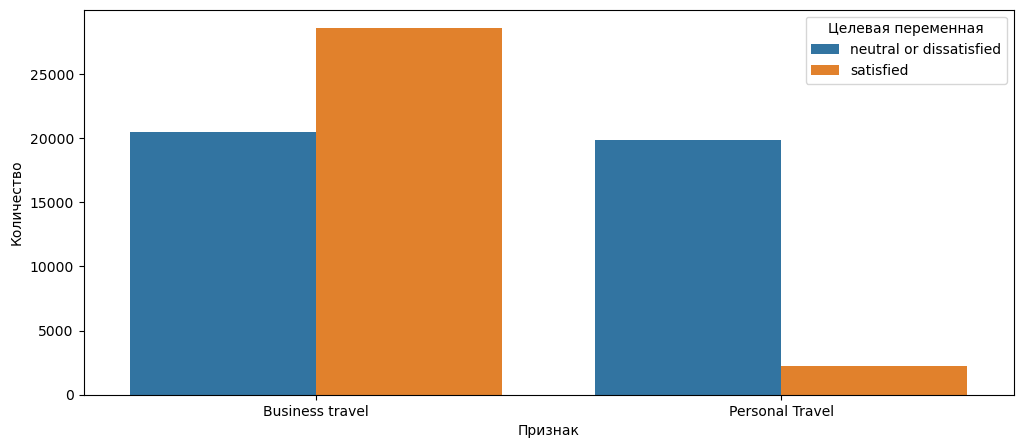

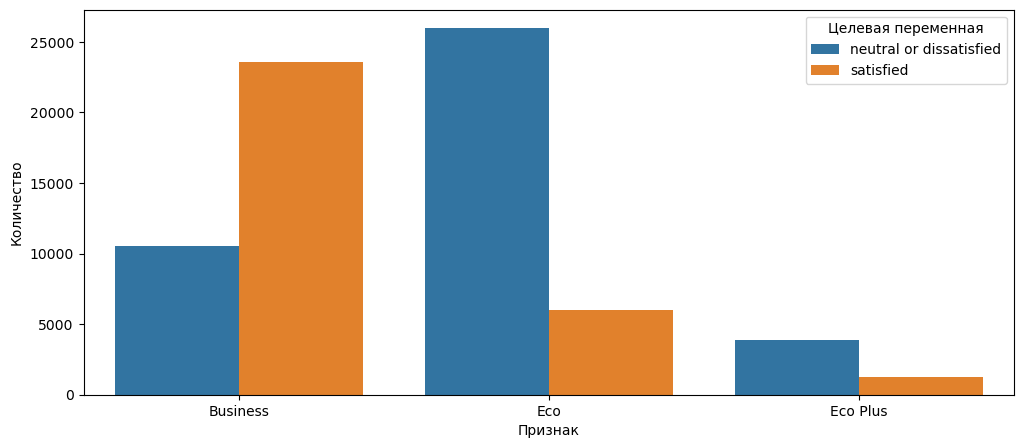

In [198]:
plot_categorical(categorical_cols, X_train, y_train)

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


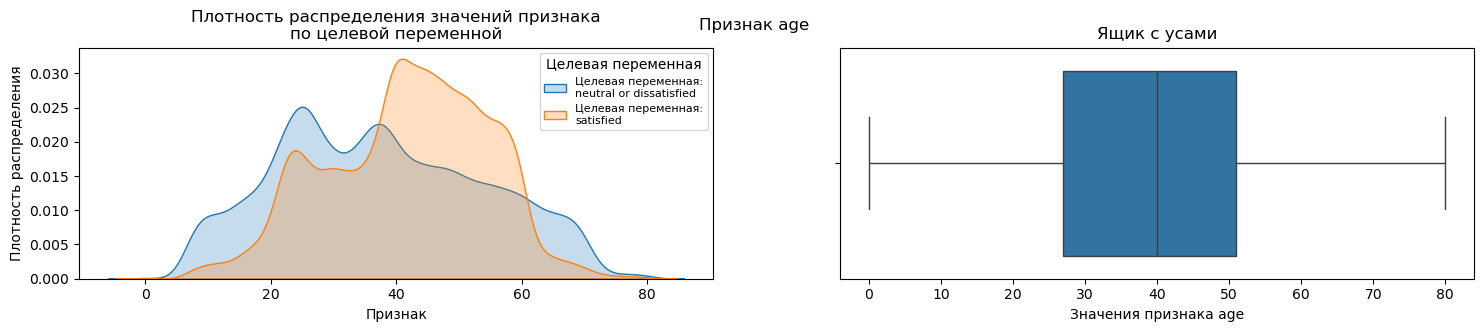

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


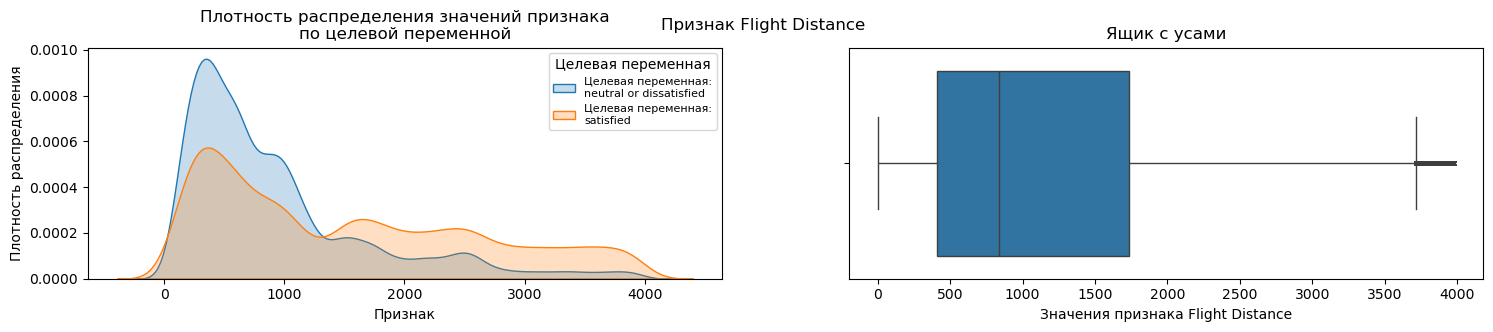

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


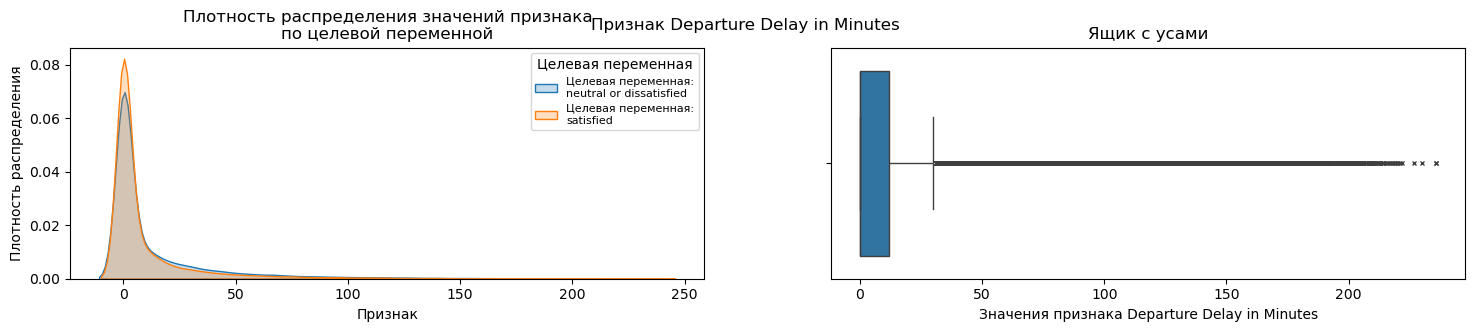

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


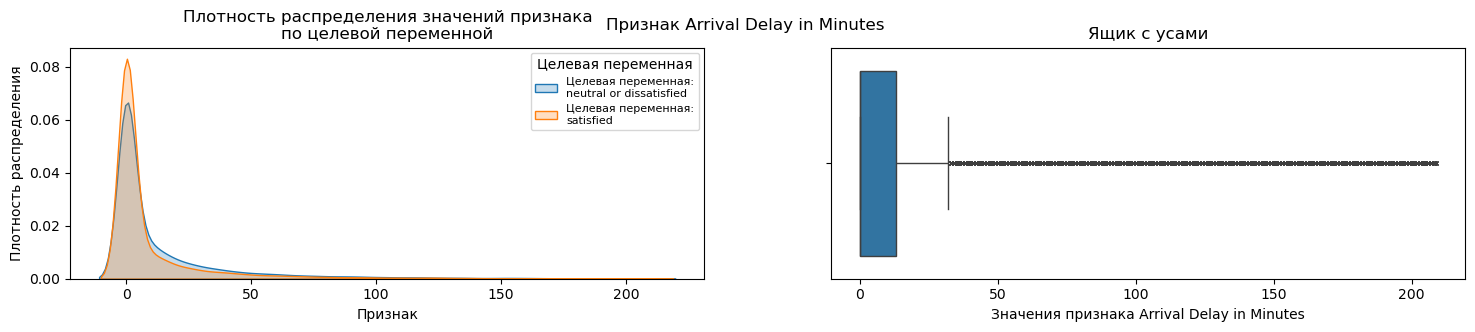

In [199]:
plot_continuous(continuous_cols, X_train, y_train)

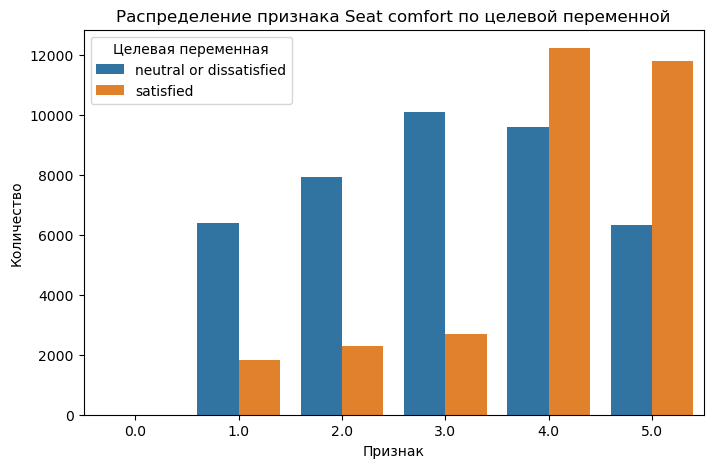

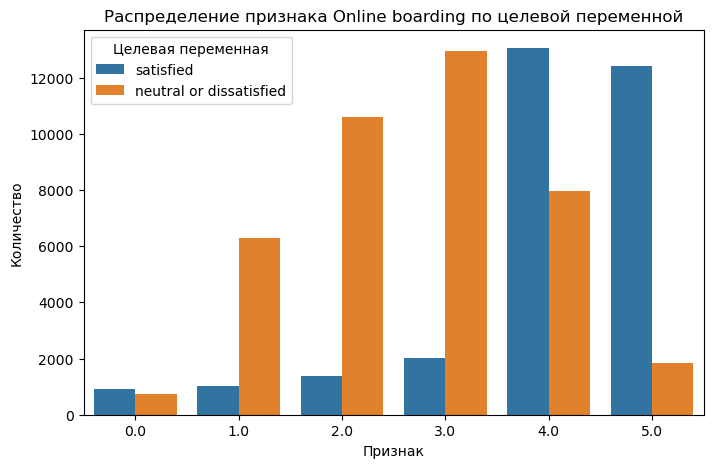

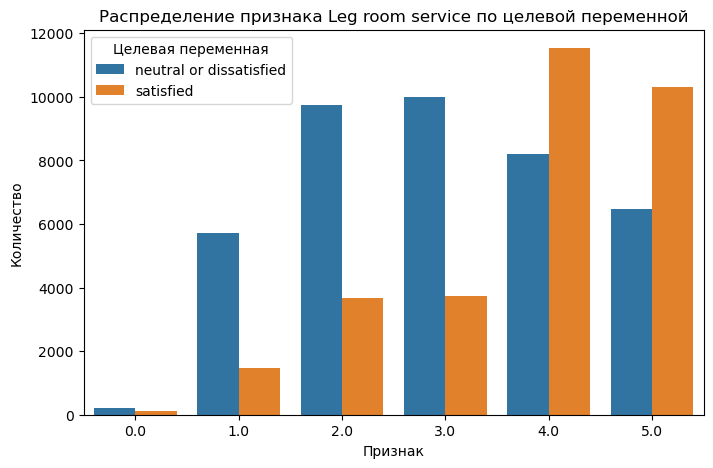

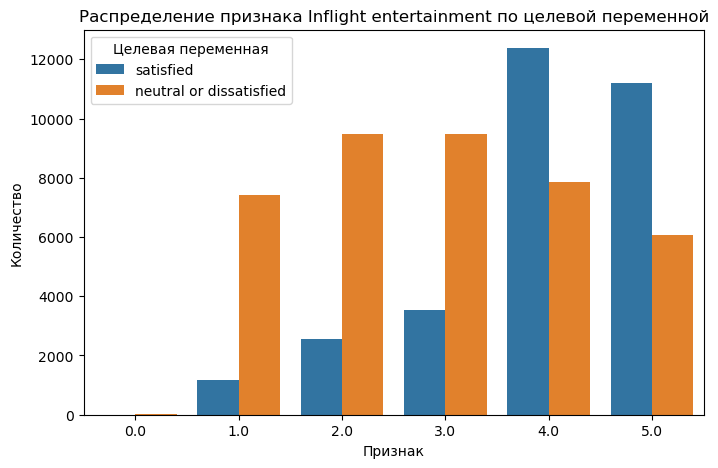

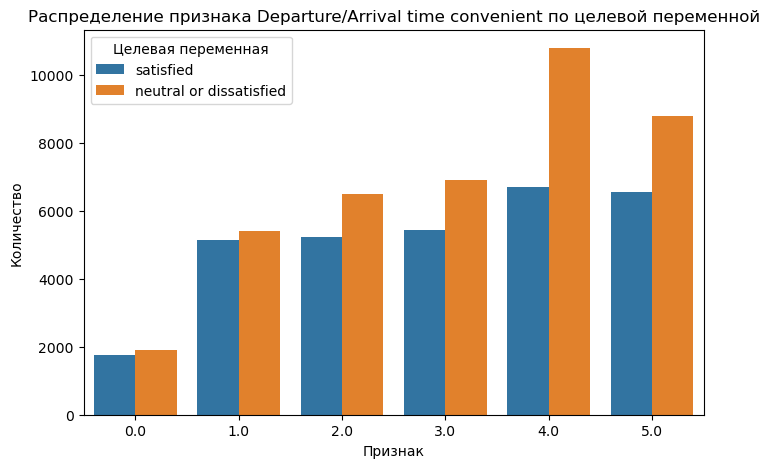

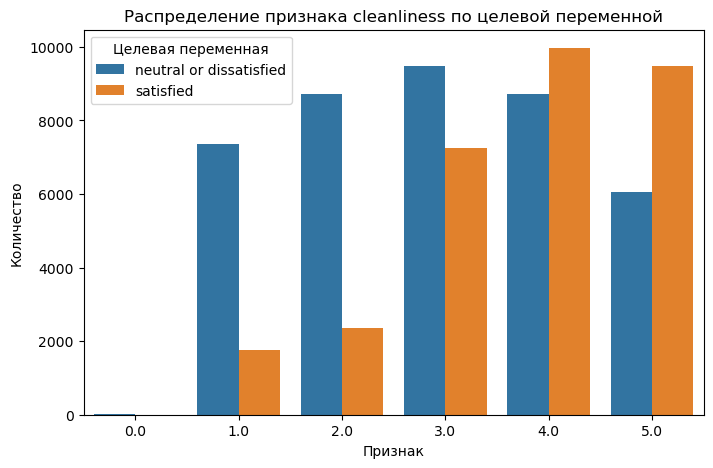

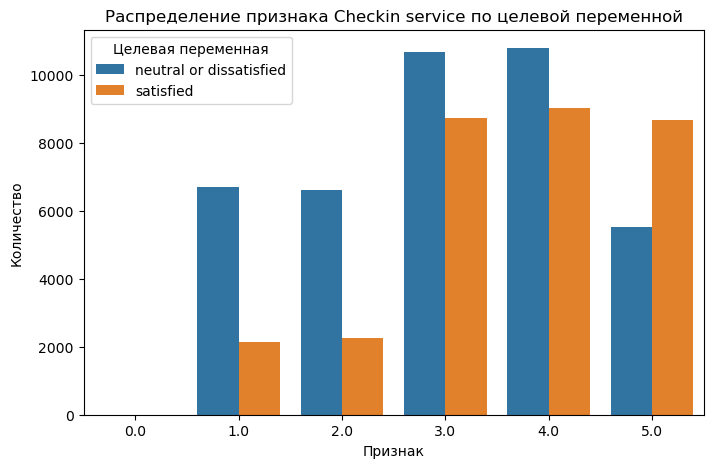

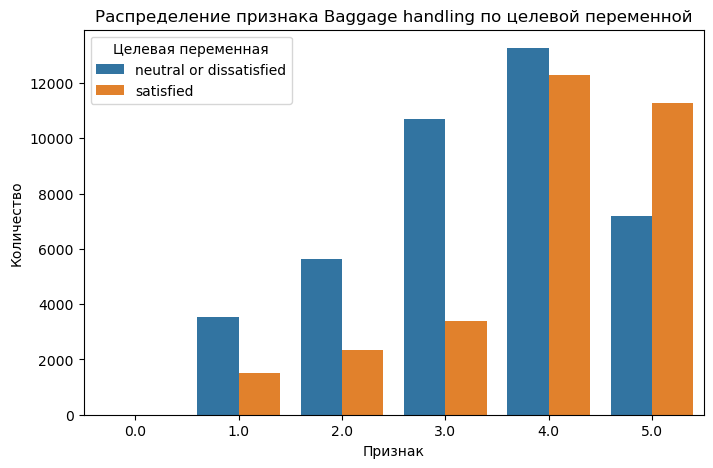

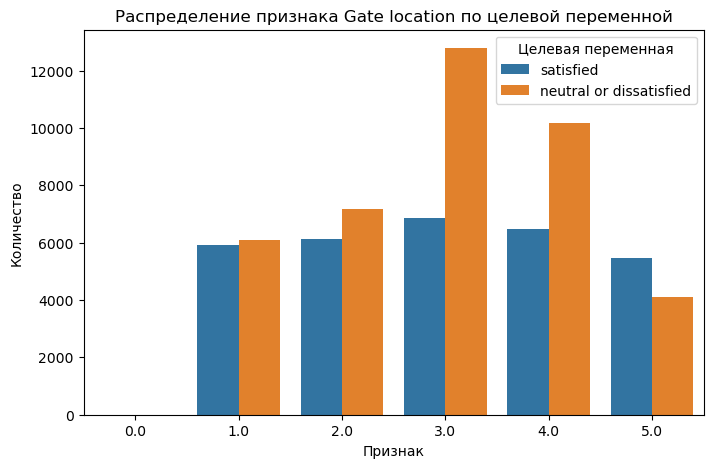

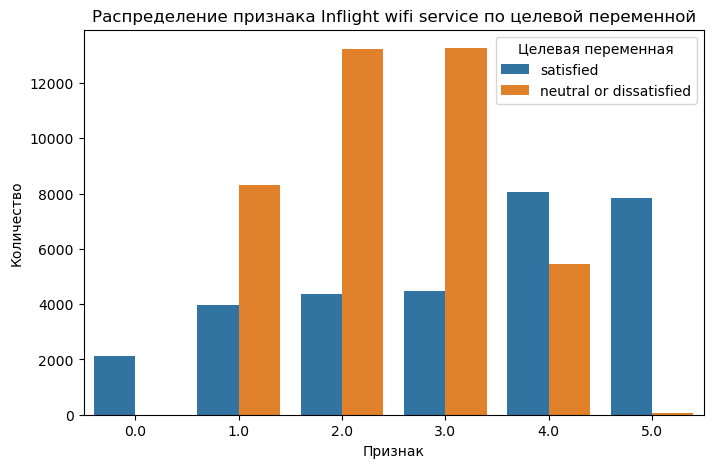

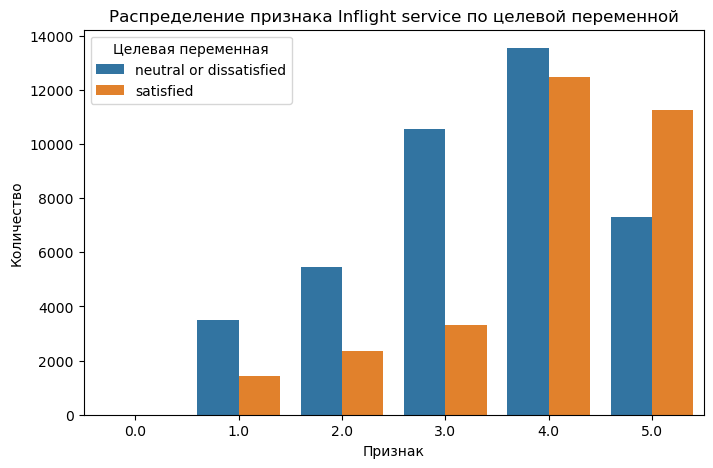

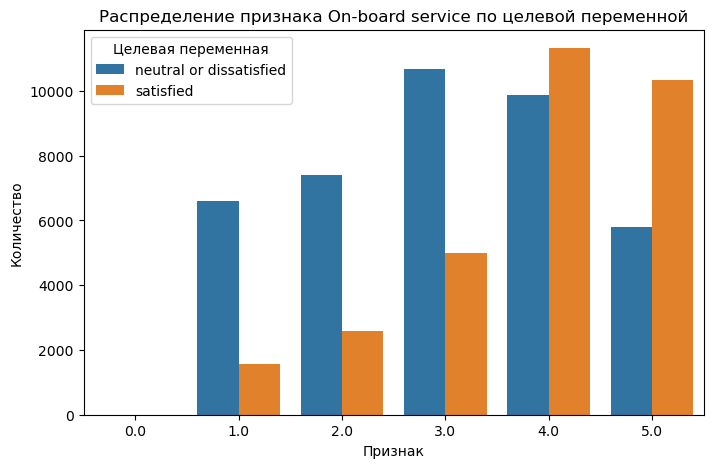

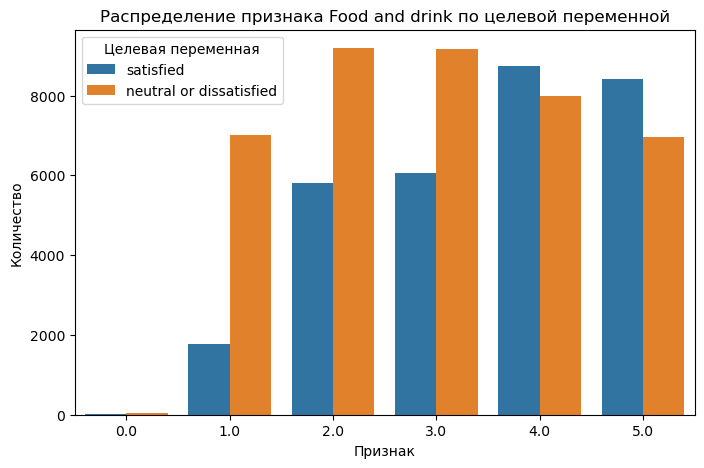

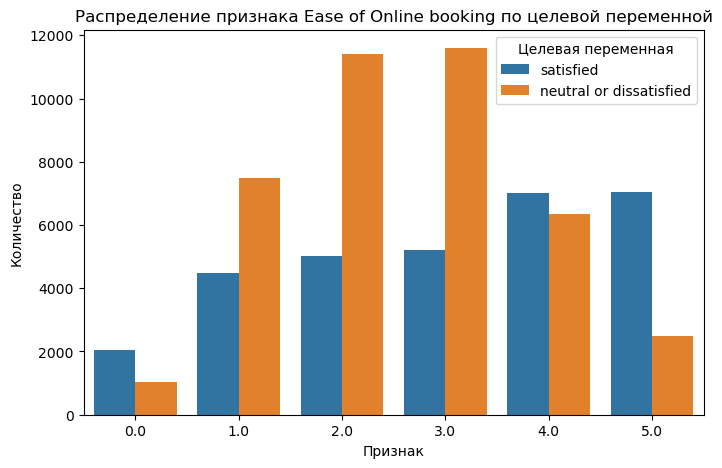

In [200]:
plot_ordinal(ordinal_cols, X_train, y_train)

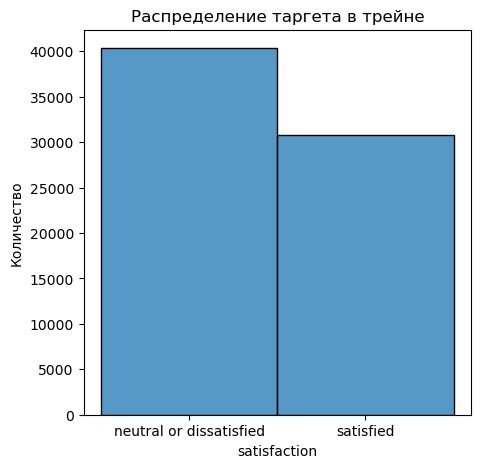

In [201]:
# visualize y_train
plt.figure(figsize=(5, 5))
sns.histplot(data=y_train)
plt.title('Распределение таргета в трейне')
plt.ylabel('Количество')
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки


```
Ваш ответ здесь
```



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [202]:
# Ваш код ниже


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [203]:
X_train['Departure Delay in Minutes'] = X_train['Departure Delay in Minutes'].apply(lambda x: np.log(x) if x != 0 else x)
X_train['Arrival Delay in Minutes'] = X_train['Arrival Delay in Minutes'].apply(lambda x: np.log(x) if x != 0 else x)
X_val['Departure Delay in Minutes'] = X_val['Departure Delay in Minutes'].apply(lambda x: np.log(x) if x != 0 else x)
X_val['Arrival Delay in Minutes'] = X_val['Arrival Delay in Minutes'].apply(lambda x: np.log(x) if x != 0 else x)

Построение.

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


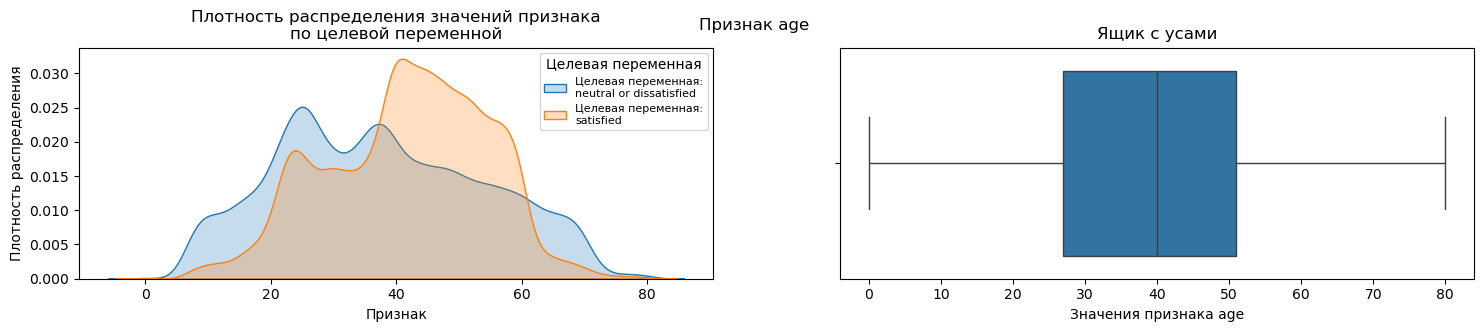

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


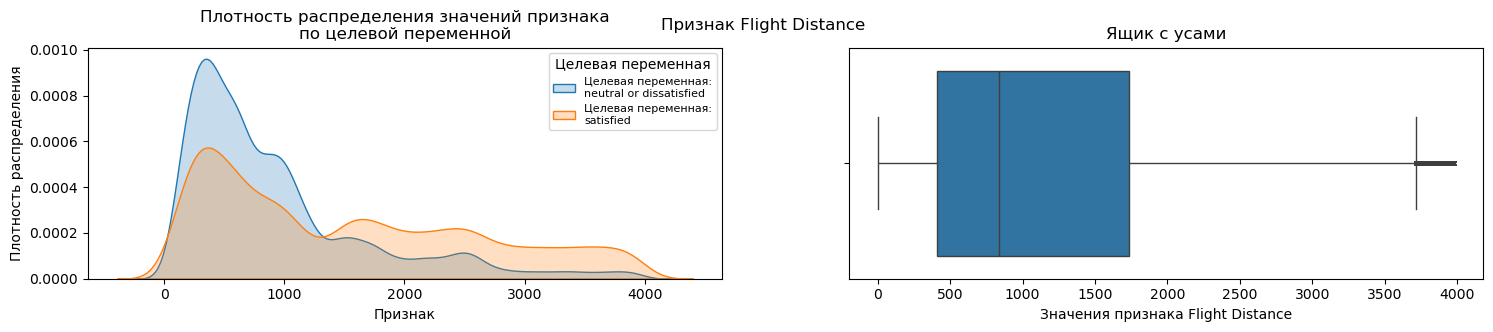

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


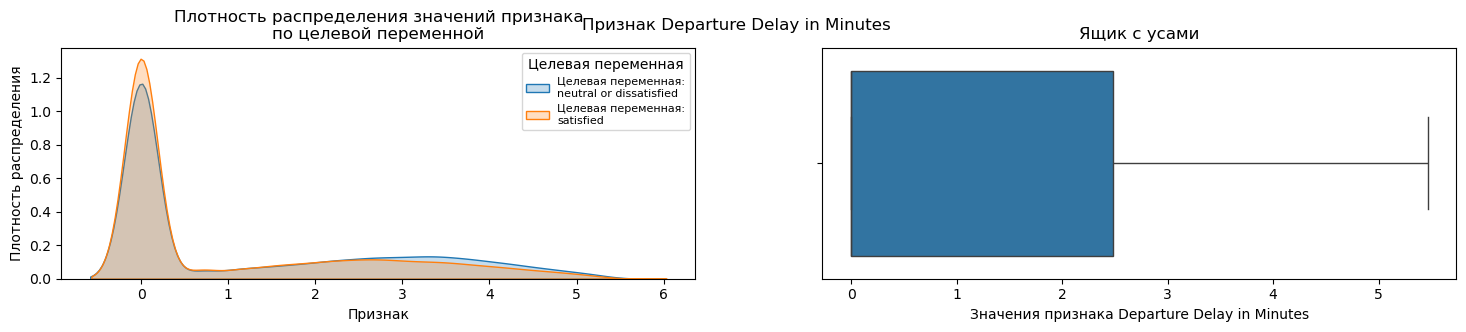

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


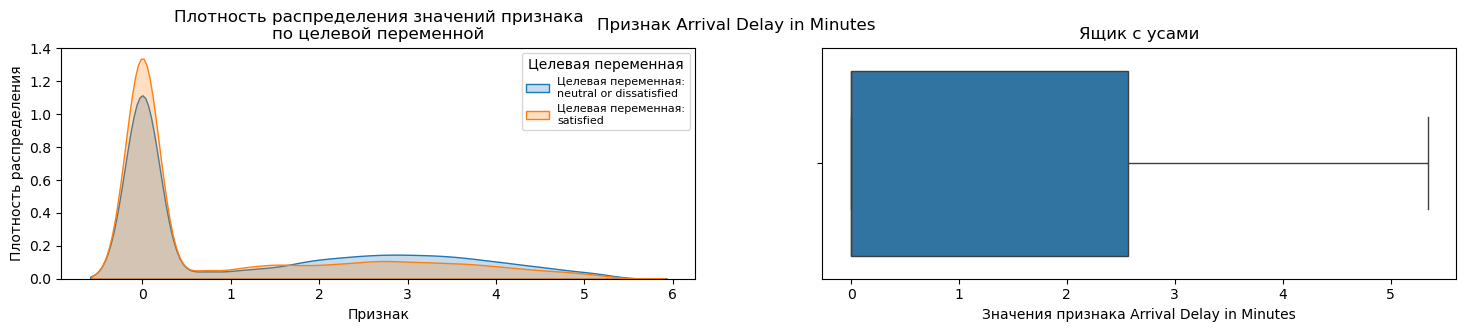

In [204]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [205]:
# Ваш код ниже



# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [206]:
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)
y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)

In [207]:
columns_to_OHE = X_train.select_dtypes(object).columns.to_list()
X_train = pd.get_dummies(X_train, columns=columns_to_OHE, drop_first=True)
X_val = pd.get_dummies(X_val, columns=columns_to_OHE, drop_first=True)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [208]:
X_val

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,class_Eco,class_Eco Plus
id,,,,,,,,,,,,,,,,,,,,,
62191,55.0,1065.0,0.000000,0.000000,3.0,3.0,3.0,3.0,1.0,4.0,...,4.0,4.0,2.0,4.0,3.0,True,False,False,False,False
71183,43.0,733.0,0.000000,0.000000,5.0,5.0,1.0,5.0,4.0,4.0,...,4.0,4.0,4.0,4.0,3.0,True,False,False,False,False
128411,23.0,370.0,3.951244,3.850148,2.0,1.0,2.0,3.0,2.0,2.0,...,4.0,3.0,1.0,3.0,2.0,True,True,False,True,False
12840,35.0,489.0,1.791759,2.484907,2.0,3.0,2.0,3.0,5.0,2.0,...,5.0,1.0,4.0,1.0,5.0,False,False,True,True,False
28753,24.0,1024.0,1.609438,1.791759,4.0,4.0,4.0,3.0,5.0,4.0,...,2.0,3.0,1.0,4.0,5.0,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89044,47.0,2116.0,3.178054,2.484907,4.0,4.0,4.0,4.0,2.0,4.0,...,4.0,4.0,5.0,4.0,4.0,True,False,False,False,False
83327,46.0,2105.0,0.000000,1.791759,3.0,3.0,3.0,3.0,2.0,4.0,...,2.0,3.0,3.0,3.0,4.0,True,False,False,False,False
81876,32.0,2305.0,0.000000,0.000000,1.0,1.0,1.0,1.0,4.0,4.0,...,3.0,4.0,3.0,4.0,4.0,True,False,False,False,False


In [209]:
model = DecisionTreeClassifier()

model.fit(X_train, y_train)
pred = model.predict(X_val)

In [210]:
accuracy_score(model.predict(X_train), y_train), accuracy_score(pred, y_val)

(1.0, 0.9425536100727917)

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [211]:
# Ваш код ниже — дополните его

error_dt, bias_dt, var_dt = bias_variance_decomp(
        model, X_train.to_numpy(), y_train.to_numpy(), X_val.to_numpy(), y_val.to_numpy(), 
        loss='0-1_loss',
        random_seed=42)
error_dt, bias_dt, var_dt

(0.06169584890812512, 0.040166568299560626, 0.04589317332284085)

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [212]:
model.get_depth(), model.get_n_leaves()

(33, 2026)

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

C:\Users\vdl\AppData\Local\Temp\ipykernel_16188\2417336348.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score_DT', y='feature', data=df_importance, palette='tab10')


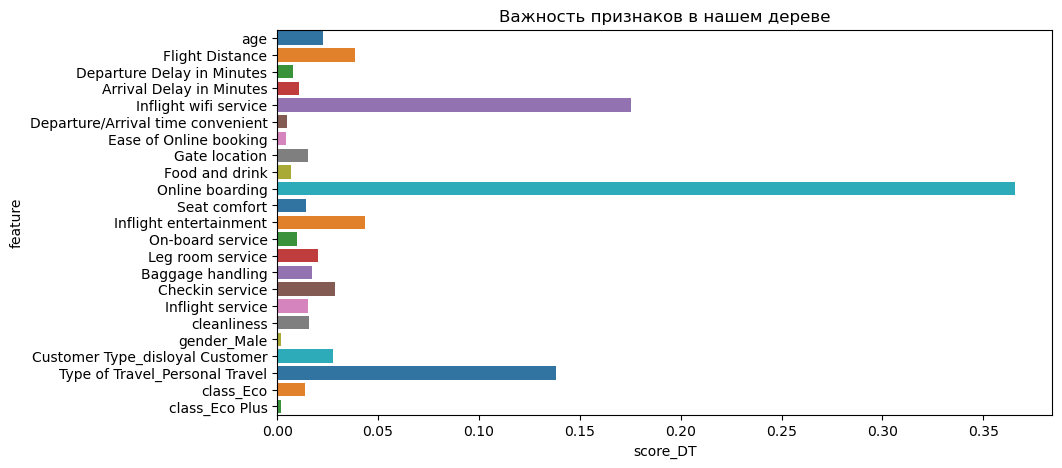

In [213]:
columns = X_train.columns
weights = model.feature_importances_

df_importance = pd.DataFrame({'feature': columns, 'score_DT': weights})

plt.figure(figsize=(10, 5))
sns.barplot(x='score_DT', y='feature', data=df_importance, palette='tab10')
plt.title('Важность признаков в нашем дереве')
plt.xlabel('score_DT')
plt.ylabel('feature')
plt.show()

`Ваш ответ здесь.`  

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [214]:
model2 = DecisionTreeClassifier(
    max_depth=5
)

X_train2 = X_train[['Online boarding', 'Inflight wifi service']]
X_val2 = X_val[['Online boarding', 'Inflight wifi service']]
model2.fit(X_train2, y_train)
pred_val2 = model2.predict(X_val2)
pred_train2 = model2.predict(X_train2)

In [215]:
accuracy_score(pred_train2, y_train), accuracy_score(pred_val2, y_val)

(0.820990516332982, 0.8251032854613417)

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

`Ваш ответ здесь. `

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

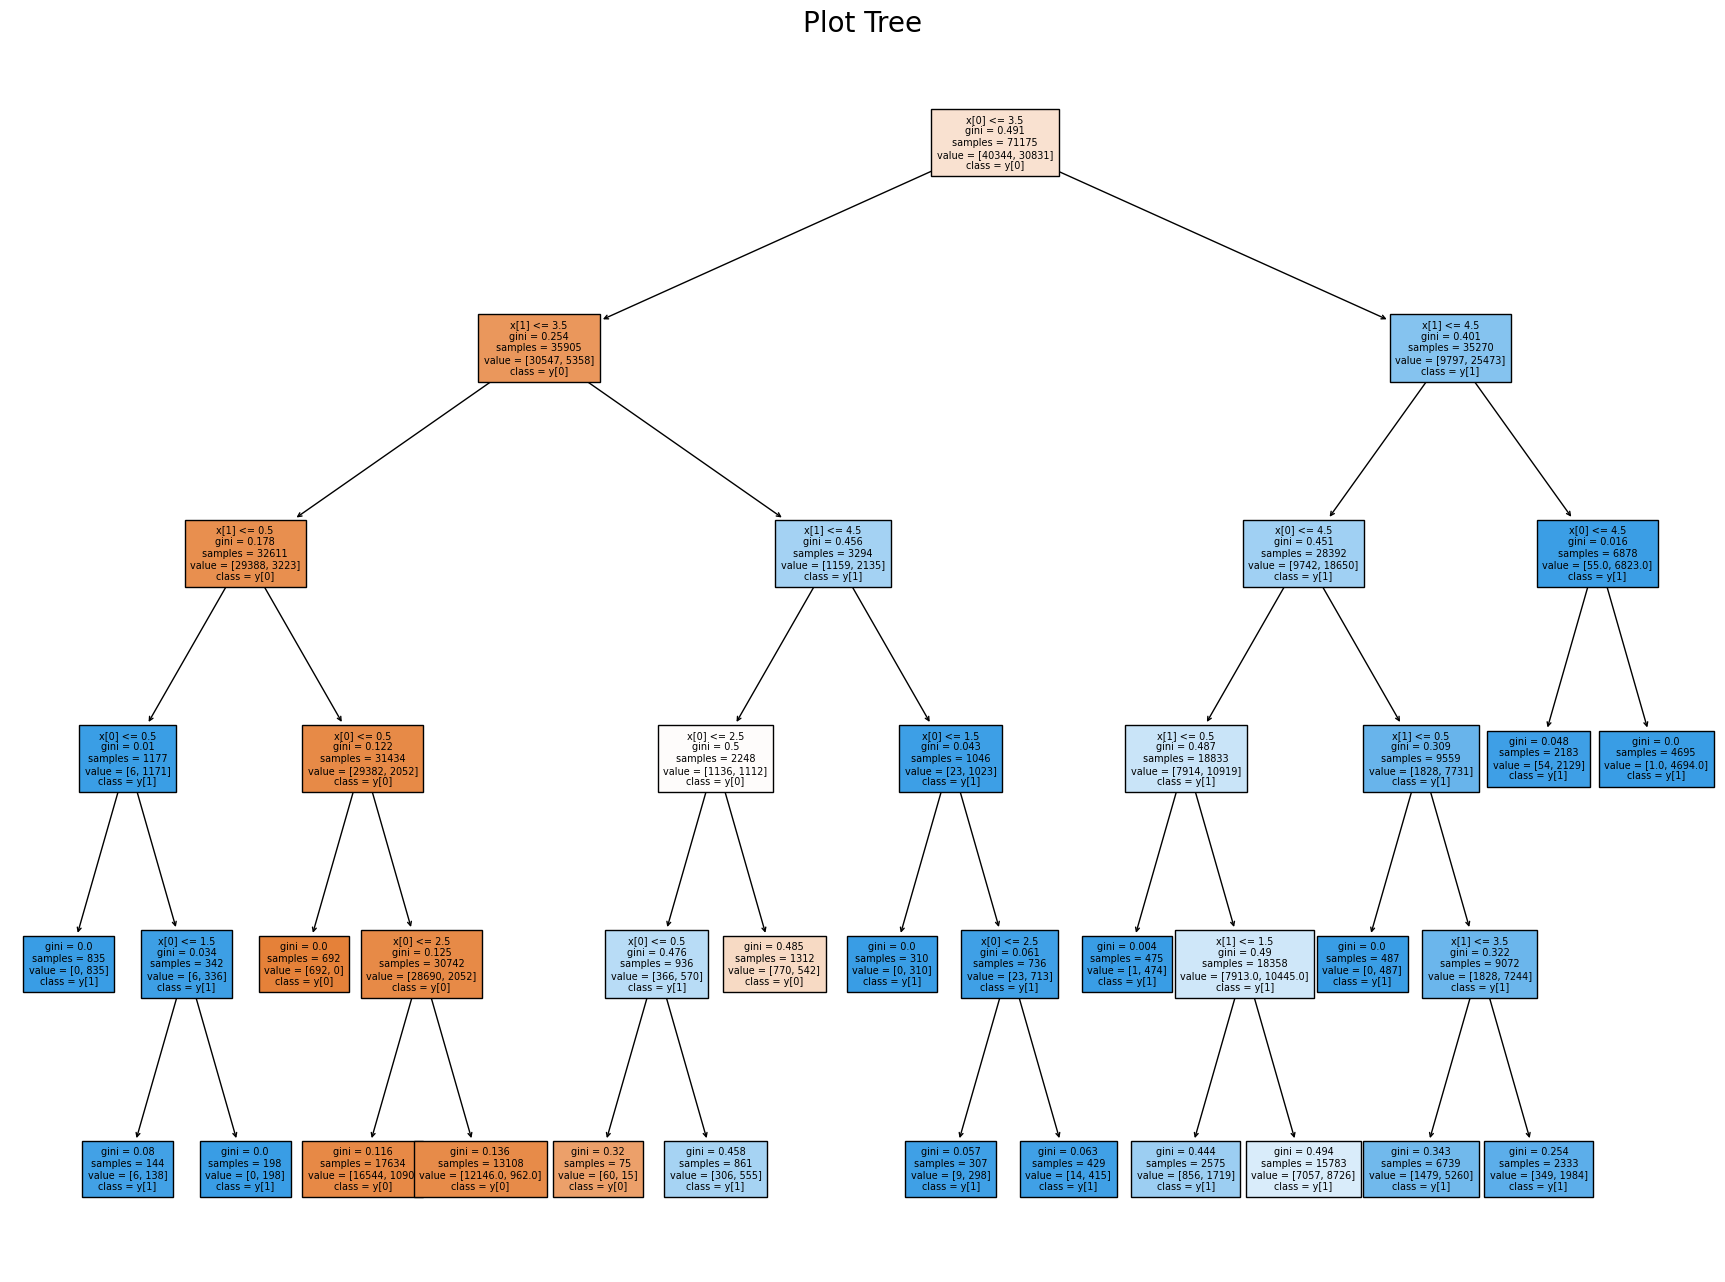

In [216]:
plt.figure(figsize=(22, 16))
plot_tree(model2, filled=True, class_names=True, fontsize=7)
plt.title('Plot Tree', fontsize=20)
plt.show()

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

In [217]:
y_train.to_numpy()[:100][1]

1

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Axes: >

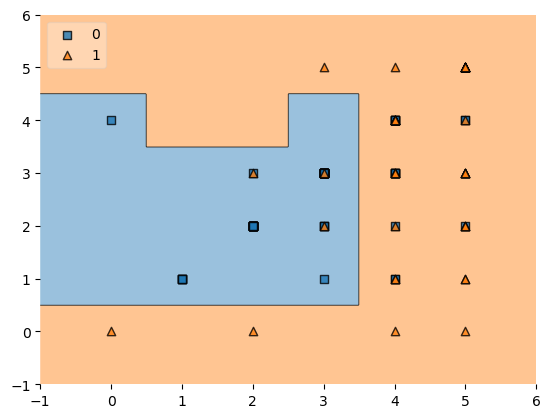

In [218]:
from sklearn.decomposition import PCA

y_train2 = y_train.to_numpy()[:100]
plot_decision_regions(X_train2.to_numpy()[:100], y_train2, model2, legend=2)

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


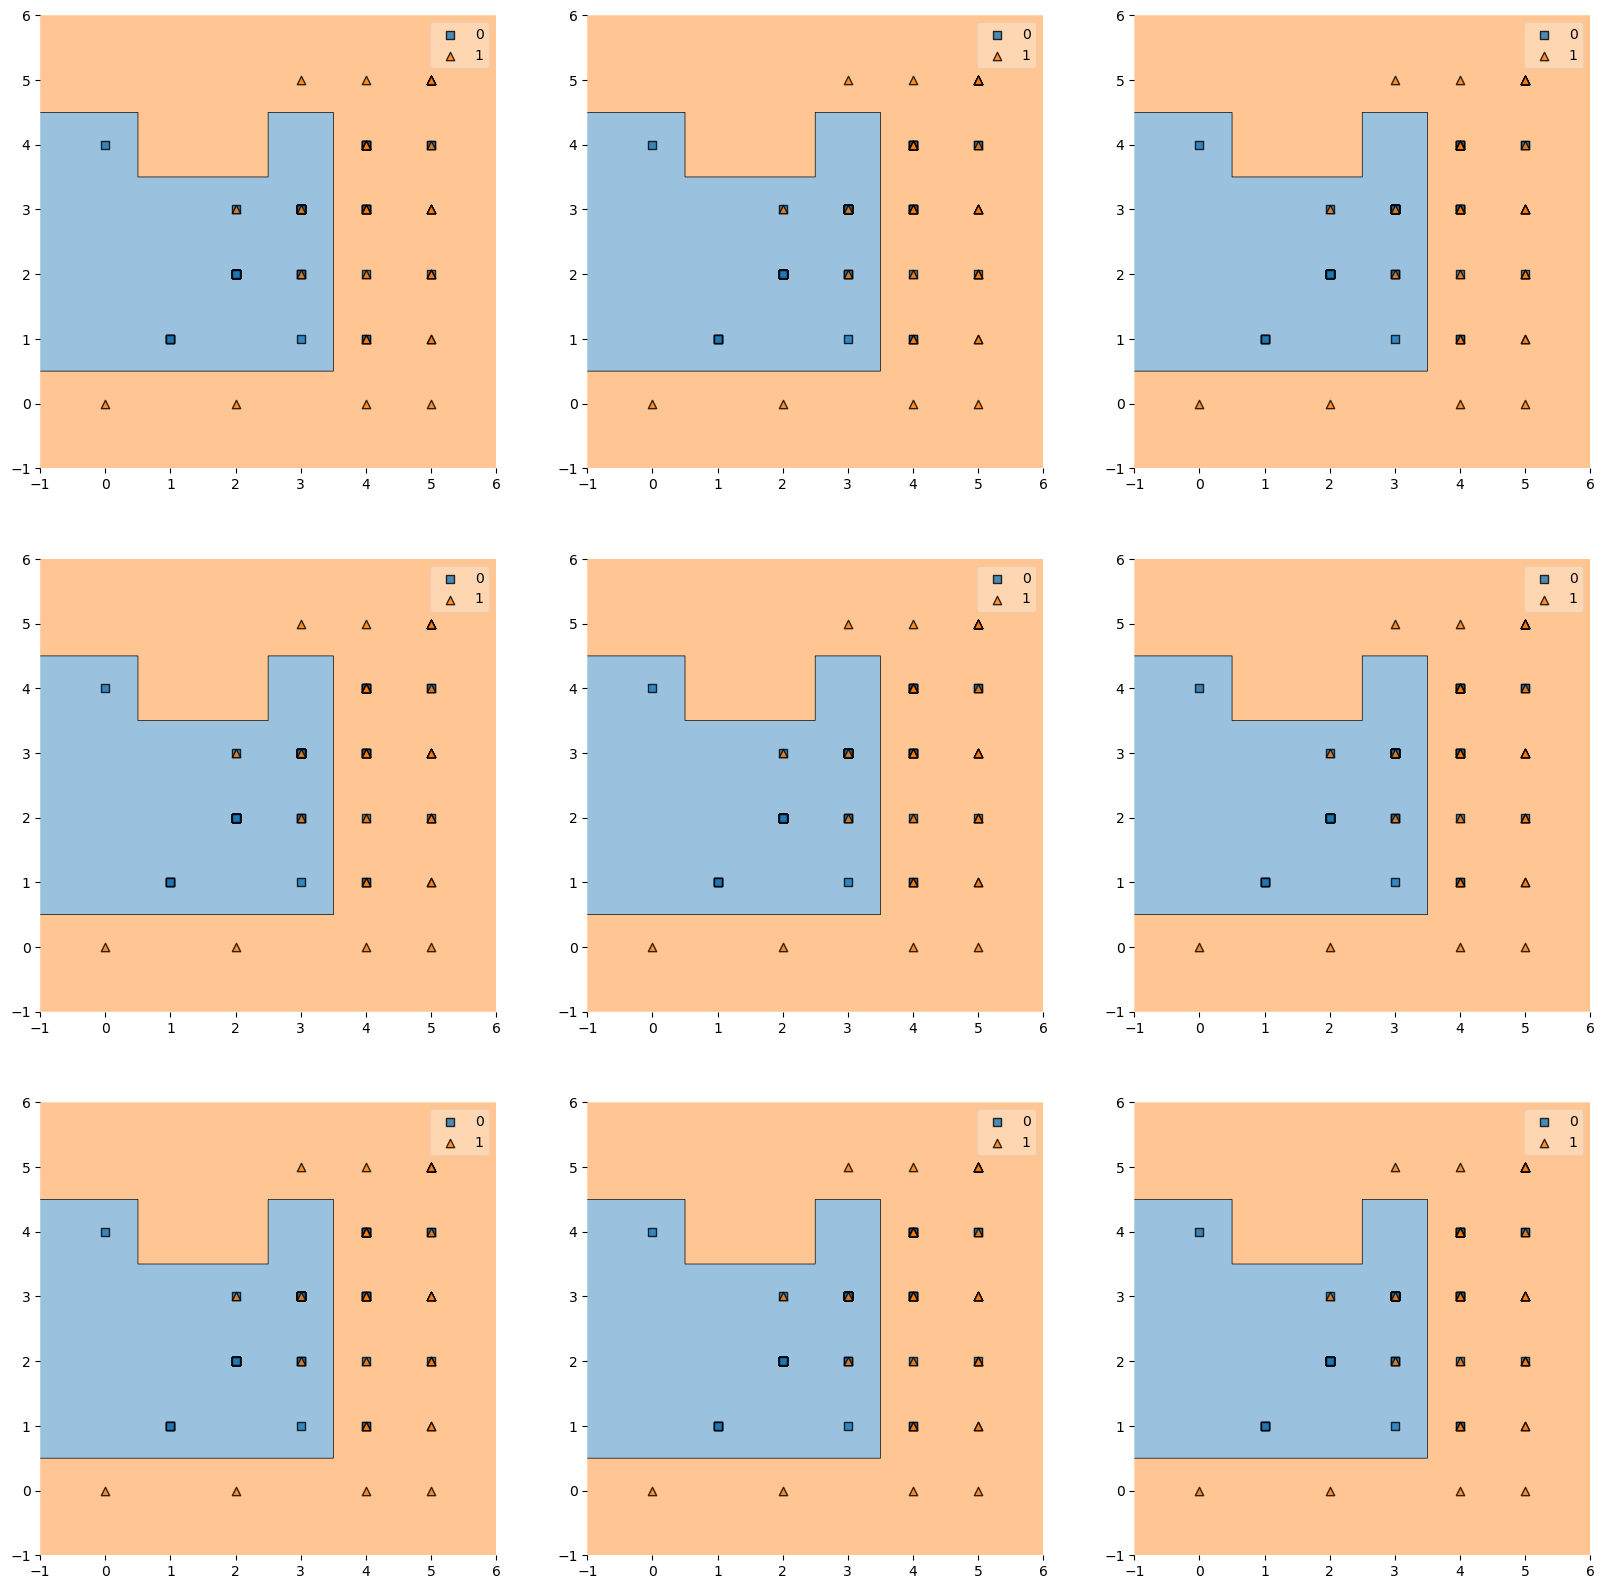

In [219]:
# замените X_train_example на вашу переменную

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train2.index, size=X_train2.shape[0] - 5000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train2.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train2.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [220]:
%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train2, y_train)
    y_predicted_train = DT.predict(X_train2)
    y_predicted_val = DT.predict(X_val2)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: total: 281 ms
Wall time: 337 ms


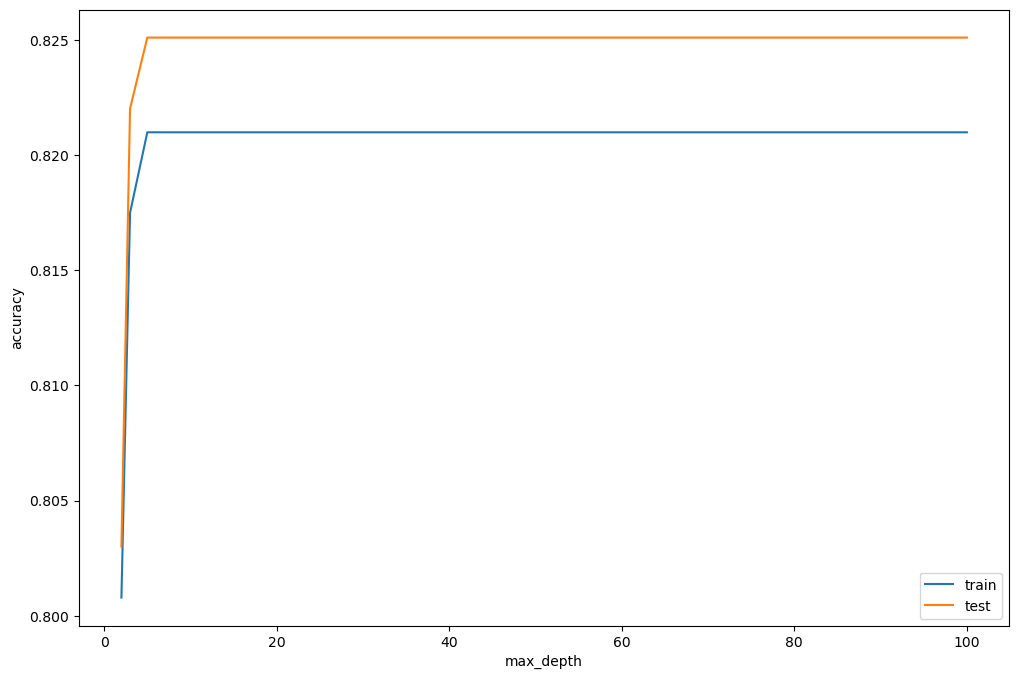

In [221]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [231]:
params = {
    'max_depth' : np.arange(1, 20),
    'min_samples_split' : np.arange(2, 20, 2),
    'min_samples_leaf' : np.arange(1, 20, 2),
    'max_features' : np.arange(1, 5)
          }

gs = GridSearchCV(DecisionTreeClassifier(), params, cv=3, scoring='roc_auc')

gs.fit(X_train, y_train)

gs.best_score_, gs.best_estimator_

(0.9796780805149664,
 DecisionTreeClassifier(max_depth=17, max_features=4, min_samples_leaf=19,
                        min_samples_split=4))

In [236]:
roc_auc_score(gs.predict(X_train), y_train), roc_auc_score(gs.predict(X_val), y_val)

(0.9375496190697057, 0.9319076571005568)

In [265]:
trees = DecisionTreeClassifier(max_depth=17, max_features=4, min_samples_leaf=19, min_samples_split=4)
trees.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=17, max_features=4, min_samples_leaf=19,
                       min_samples_split=4)

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [266]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(trees, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [227]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

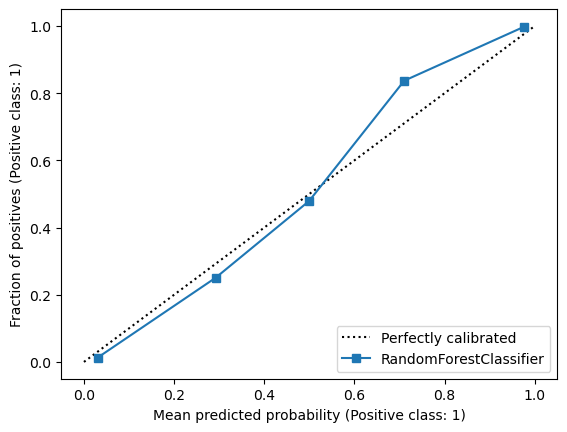

In [229]:
# Ваш код здесь

disp = CalibrationDisplay.from_estimator(random_forest, X_val, y_val)
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

Вероятности в деревьях зависят (смещаются) от cоотношения количества тех или иных объектов.То есть, если одного объекта - 800 шт, а других - 200 шт, первые будут иметь большее влияние на расчет вероятности

### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


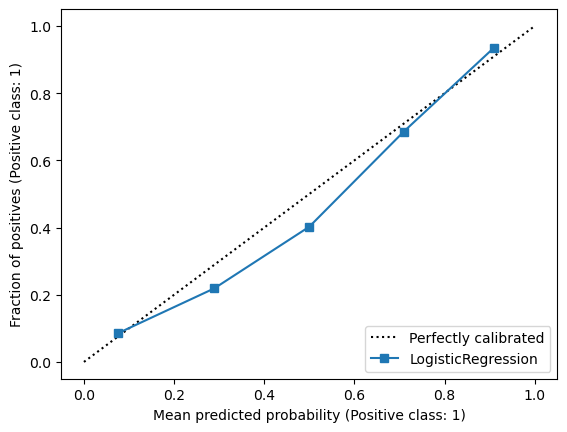

In [230]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

disp = CalibrationDisplay.from_estimator(lr, X_val, y_val)
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

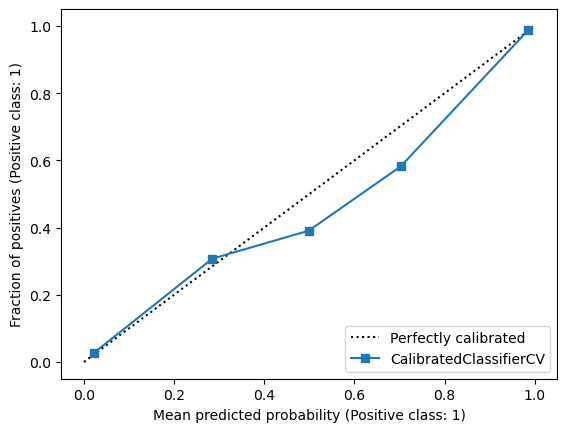

In [242]:
# Ваш код здесь (Logreg)
from sklearn.calibration import CalibratedClassifierCV

logreg = CalibratedClassifierCV(random_forest, method='sigmoid', cv=5)
logreg.fit(X_train, y_train)

disp = CalibrationDisplay.from_estimator(logreg, X_val, y_val)
plt.show()

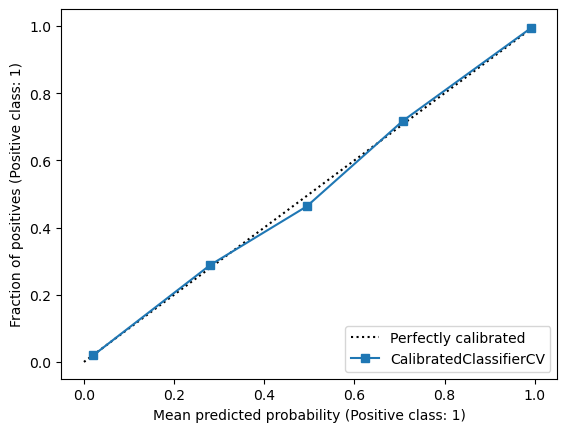

In [243]:
# Ваш код здесь (isoreg)
from sklearn.calibration import CalibratedClassifierCV

isoreg = CalibratedClassifierCV(random_forest, method='isotonic', cv=5)
isoreg.fit(X_train, y_train)

disp = CalibrationDisplay.from_estimator(isoreg, X_val, y_val)
plt.show()

изотоническая регрессия откалибровывает лучше

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)



```
Ваш ответ здесь
```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [244]:
rf_pred = random_forest.predict(X_val)

bias = np.mean((np.mean(rf_pred, axis=0) - y_val) ** 2)  # Смещение
variance = np.mean(np.var(rf_pred, axis=0))
bias, variance

(0.24561087078074909, 0.24305282286716323)

отличаются значительно. у дерева решений на 0,2 меньше

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [245]:
params = {'n_estimators': np.arange(100, 1000, 50),
               'max_depth': np.arange(1, 20, 1),
               'min_samples_split': np.arange(1, 20, 2),
               'min_samples_leaf': np.arange(2, 20, 2)}
rs = RandomizedSearchCV(random_forest, 
                        params, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=42)
rs.fit(X_train, y_train)
rs.best_score_, rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
24 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  

(0.9577941693010187,
 {'n_estimators': 150,
  'min_samples_split': 3,
  'min_samples_leaf': 2,
  'max_depth': 17})

In [255]:
rs.best_params_

{'n_estimators': 150,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_depth': 17}

In [259]:
random_trees = RandomForestClassifier(n_estimators=150, min_samples_split = 3, min_samples_leaf = 2, max_depth = 17)

random_trees.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=150)

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [247]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\vdl\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: 

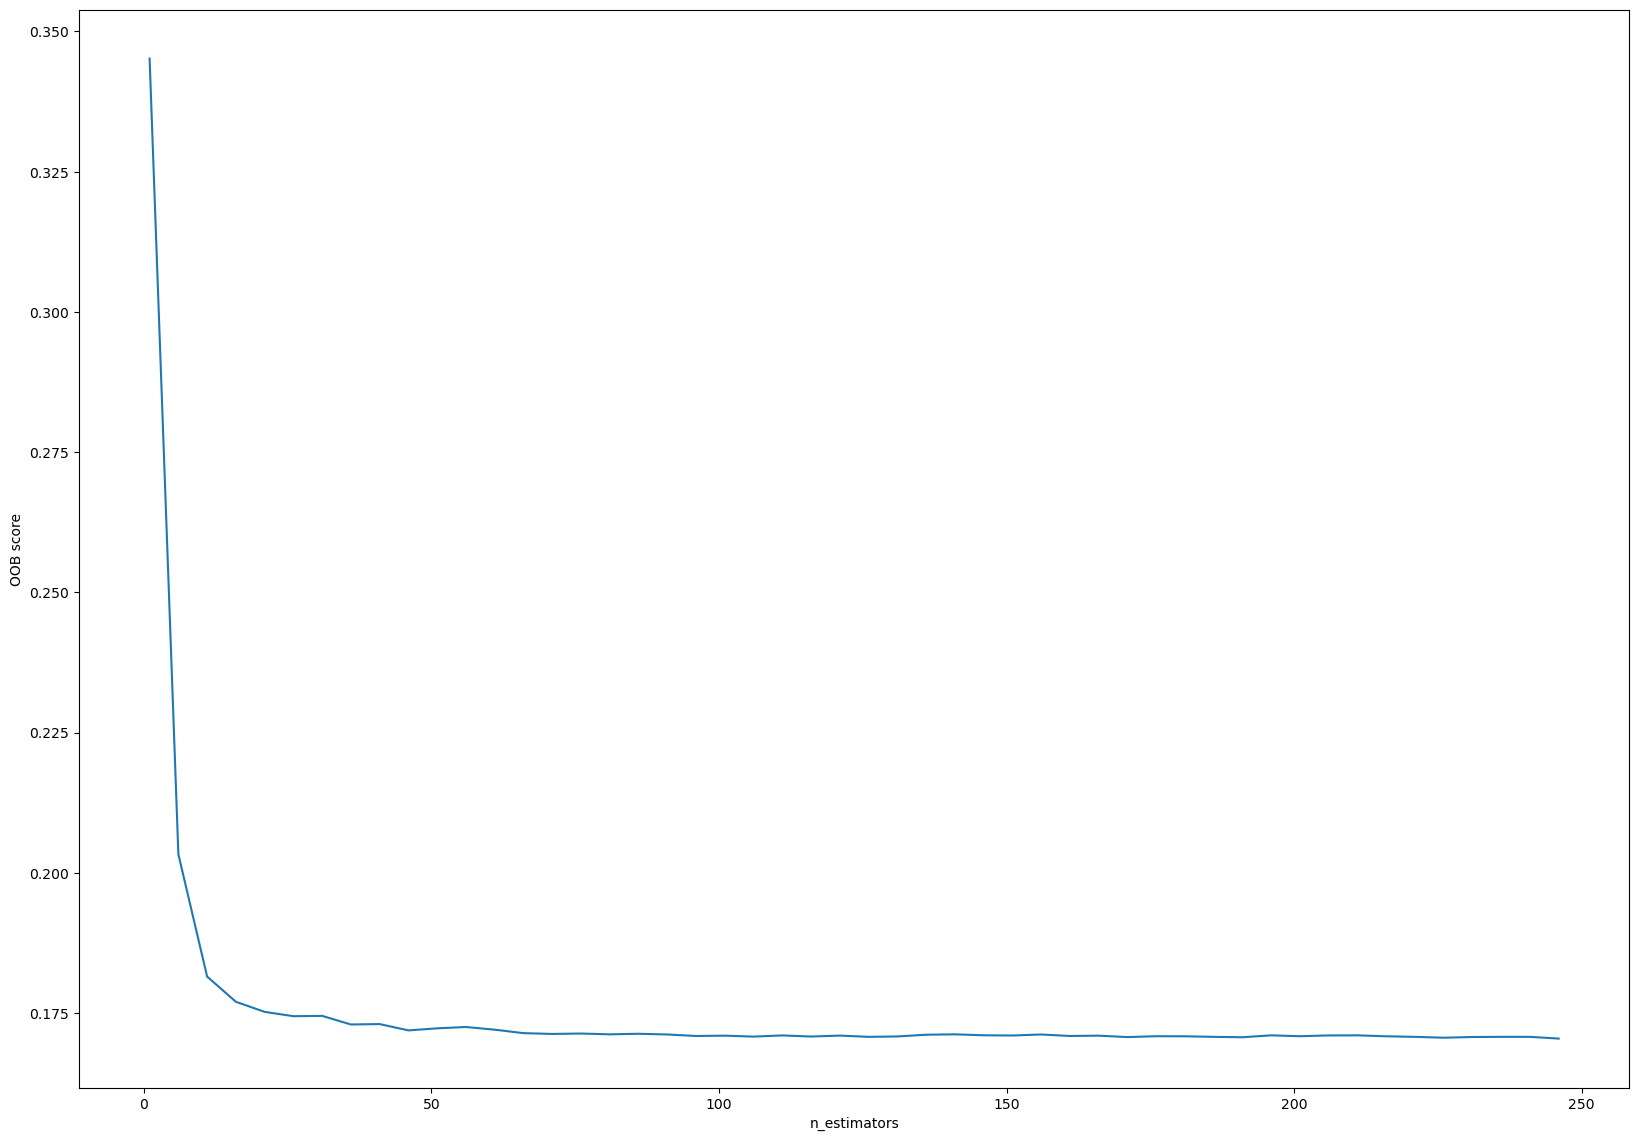

In [248]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [260]:
random_trees.feature_importances_

array([0.02498176, 0.03220859, 0.0067953 , 0.00850599, 0.14670694,
       0.01583867, 0.03819433, 0.01238426, 0.00995165, 0.18627755,
       0.05536615, 0.05892748, 0.03417372, 0.04016227, 0.02028501,
       0.02027293, 0.02407793, 0.02707737, 0.00308664, 0.03846754,
       0.11883407, 0.07261899, 0.00480487])

C:\Users\vdl\AppData\Local\Temp\ipykernel_16188\630253444.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score_trees', y='feature', data=df_importance, palette='tab10')


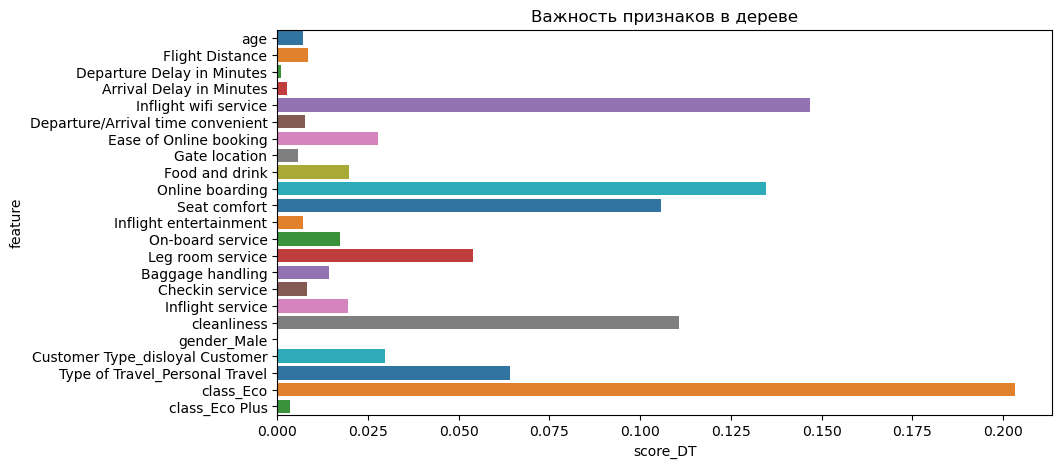

C:\Users\vdl\AppData\Local\Temp\ipykernel_16188\630253444.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score_rand_trees', y='feature', data=df_importance, palette='tab10')


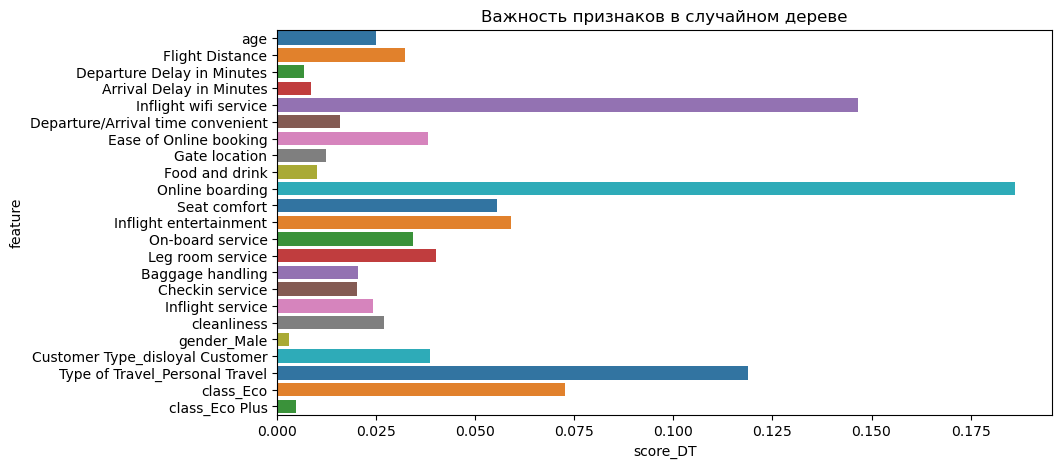

In [288]:
columns = X_train.columns
weights_trees = trees.feature_importances_
weights_random_trees = random_trees.feature_importances_

df_importance = pd.DataFrame({'feature': columns, 'score_trees': weights_trees, 'score_rand_trees': weights_random_trees})

plt.figure(figsize=(10, 5))
sns.barplot(x='score_trees', y='feature', data=df_importance, palette='tab10')
plt.title('Важность признаков в дереве')
plt.xlabel('score_DT')
plt.ylabel('feature')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='score_rand_trees', y='feature', data=df_importance, palette='tab10')
plt.title('Важность признаков в случайном дереве')
plt.xlabel('score_DT')
plt.ylabel('feature')
plt.show()

In [289]:
with open('random_tree.pkl', 'wb') as f:
    pickle.dump(random_trees, f)

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

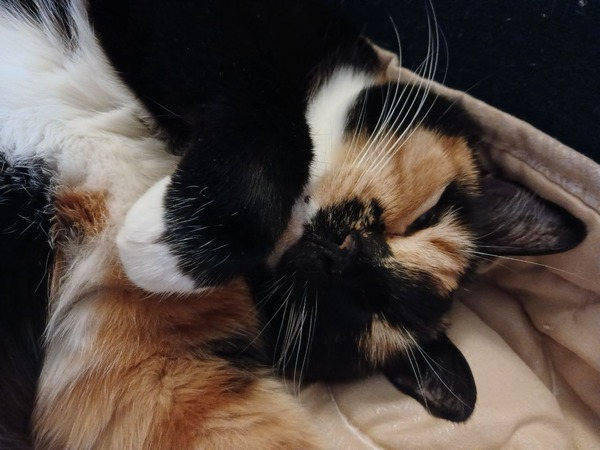

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?